In [41]:
import time 
import itertools 
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import mujoco
import distutils.util
import os
import subprocess


""

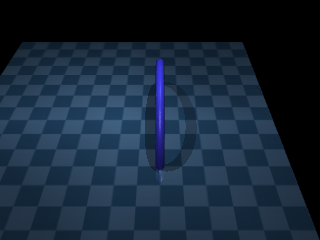

In [75]:


np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Defining the wheel here...
xml = """
<mujoco>
  <extension>
    <plugin plugin="mujoco.sdf.torus">
      <instance name="torus">
        <config key="radius1" value="1.5"/>
        <config key="radius2" value="0.10"/>
      </instance>
    </plugin>
  </extension>

  <asset>
    <mesh name="torus">
      <plugin instance="torus"/>
    </mesh>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <option sdf_iterations="10" sdf_initpoints="40"/>

  <default>
    <geom solref="0.01 1" solimp=".95 .99 .0001" friction="0.1"/>
  </default>

  <worldbody>
      <geom size="4 4 4" type="plane" material="grid"/>
    <body pos="1 0 0">
      <freejoint/>
      <geom type="sdf" mesh="torus" rgba=".2 .2 .8 1" euler="10 90 10" >
        <plugin instance="torus"/>
      </geom>
      <inertial pos="0.3 0 0" mass="4" diaginertia="1 1 1"/>
    </body>
    <light name="left" pos="-2 0 7" cutoff="80"/>
    <light name="right" pos="2 0 7" cutoff="80"/>
    
  </worldbody>
  <keyframe>
    <key name="spinning" qpos="0 0 3 0 0 0 0" qvel="0 2 0 0 0 0" />  #See read.me for d.o.f
  </keyframe>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml) # this makes a model out of the xml such that we can use it. 

data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
# media.show_image(renderer.render())

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

Render the video

In [12]:
#Specify location of ffmpeg
import os

# Specify the full path to ffmpeg
ffmpeg_path = "/opt/homebrew/bin/ffmpeg"

# Update the PATH environment variable to include the directory containing ffmpeg
os.environ['PATH'] += os.pathsep + os.path.dirname(ffmpeg_path)


In [4]:
print('positions', data.qpos)
print('velocities', data.qvel)

positions [1. 0. 0. 1. 0. 0. 0.]
velocities [0. 0. 0. 0. 0. 0.]


In [76]:
duration = 5    # (seconds)
framerate = 60  # (Hz) increase to 60 for smooth video

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

In [8]:
def render(xml, duration, framerate):
    model = mujoco.MjModel.from_xml_string(xml) # this makes a model out of the xml such that we can use it. 

    data = mujoco.MjData(model)

    # Make renderer, render and show the pixels
    renderer = mujoco.Renderer(model)
    # media.show_image(renderer.render())

    mujoco.mj_forward(model, data)
    renderer.update_scene(data)

    #media.show_image(renderer.render())

    # Simulate and display video.
    frames = []
    mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)

    media.show_video(frames, fps=framerate)

In [9]:
render(xml, 7, 20)